## 라이브러리 import

In [1]:
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, accuracy_score, log_loss, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

import optuna
from optuna.samplers import TPESampler
from tqdm import tqdm


plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
sns.set(font_scale = 1)  
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("Let's start!")

Let's start!


## 와인 품질 예측!

<br>

<img 
     src="http://masism.kr/wp-content/uploads/2020/09/C-3.jpg">
     
<br>

<br>

## 데이터 로드

데이터는 train, test 데이터 모두 3231개의 행으로 이루어져 있습니다.

독립변수는 총 12개, 종속변수는 quality입니다.

In [2]:
train = pd.read_csv("./dataset/train.csv", index_col='id')
test = pd.read_csv("./dataset/test.csv", index_col='id')

display(train.shape, train.head(3), test.shape, test.head(3))

(3231, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
id,,,,,,,,,,,,,
1,8.0,0.18,0.37,1.3,0.040,15.0,96.0,0.99120,3.06,0.61,12.1,white,6
2,7.5,0.38,0.29,4.9,0.021,38.0,113.0,0.99026,3.08,0.48,13.0,white,7
3,6.1,0.27,0.33,2.2,0.021,26.0,117.0,0.98860,3.12,0.30,12.5,white,6


(3231, 12)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
id,,,,,,,,,,,,
1,7.3,0.31,0.25,6.65,0.032,30.0,138.0,0.99244,2.90,0.37,11.1,white
2,8.7,0.70,0.24,2.50,0.226,5.0,15.0,0.99910,3.32,0.60,9.0,red
3,6.9,0.63,0.01,2.40,0.076,14.0,39.0,0.99522,3.34,0.53,10.8,red


<br>


각각의 변수들에 대한 설명은 다음과 같습니다.

* id : 식별 고유값 --> 데이터의 인덱스로만 사용할 것입니다.

* fixed acidity : 고정(비휘발성) 산도: 와인과 관련된 대부분의 산

* volatile acidity : 휘발성 산도: 와인에 함유된 아세트산의 양. 너무 높으면 불쾌한 식초 맛이 날 수 있음

* citric acid : 구연산: 소량으로 발견되며, 와인에 풍미를 더할 수 있음

* residual sugar : 잔여 당분: 발효가 멈춘 후 남은 설탕의 양으로 1g/L 미만의 와인은 드물며 45g/L 이상의 와인은 단맛으로 간주함

* chlorides : 염소화물: 와인의 염분량

* free sulfur dioxide : 유리 이산화황: 미생물의 성장과 와인의 산화를 방지함

* total sulfur dioxide : 총 이산화황: 저농도에서는 대부분 맛이 나지 않으나 50ppm 이상의 농도에서 맛에서 뚜렷하게 나타남

* density : 밀도: 알코올 및 당 함량에 따라 변함

* pH : 산성 또는 염기성 정도. 0(매우 산성) ~ 14(매우 염기성). 대부분의 와인은 pH 3-4 사이임

* sulphates : 황산염: 이산화황 농도에 기여할 수 있는 와인 첨가제. 항균 및 항산화제로 작용

* alcohol : 와인의 알코올 함량 백분율

* type : 와인에 사용된 포도의 종류. Red(적포도주), White(백포도주)로 나뉨

* quality : 맛으로 평가된 와인의 품질

<br>

## EDA


### 데이터 기본 정보


단순히 `train.info()` 만으로도 충분히 볼 수 있는 데이터이지만, 변수의 수가 100개가 넘는 데이터를 다룰 일들도 생길 것입니다.

변수의 수가 굉장히 많으면 `.info()` 메서드로는 출력이 안 될 수도 있는데요,

따라서 간단한 for문을 이용해서 각 변수의 고유한 값의 갯수까지 한 눈에 파악할 수 있도록 아래와 같이 구현해 보았습니다. 

In [3]:
train_info = pd.DataFrame(columns = ['Name of Col', 'Name of Null', 'Dtype', 'N_Unique'])

for i in range(0, len(train.columns)):
    train_info.loc[i] = [train.columns[i],
                        train[train.columns[i]].isnull().sum(),
                        train[train.columns[i]].dtypes,
                        train[train.columns[i]].nunique()]
    
train_info

,Name of Col,Name of Null,Dtype,N_Unique
0,fixed acidity,0,float64,99
1,volatile acidity,0,float64,159
2,citric acid,0,float64,86
3,residual sugar,0,float64,277
4,chlorides,0,float64,168
5,free sulfur dioxide,0,float64,115
6,total sulfur dioxide,0,float64,260
7,density,0,float64,806
8,pH,0,float64,105
9,sulphates,0,float64,101


In [4]:
test_info = pd.DataFrame(columns = ['Name of Col', 'Name of Null', 'Dtype', 'N_Unique'])

for i in range(0, len(test.columns)):
    test_info.loc[i] = [test.columns[i],
                        test[test.columns[i]].isnull().sum(),
                        test[test.columns[i]].dtypes,
                        test[test.columns[i]].nunique()]
    
test_info

,Name of Col,Name of Null,Dtype,N_Unique
0,fixed acidity,0,float64,92
1,volatile acidity,0,float64,159
2,citric acid,0,float64,84
3,residual sugar,0,float64,265
4,chlorides,0,float64,171
5,free sulfur dioxide,0,float64,106
6,total sulfur dioxide,0,float64,258
7,density,0,float64,816
8,pH,0,float64,100
9,sulphates,0,float64,97


<br>

1. null data는 없음

2. type컬럼만 object type. 향후 onehot encoding 또는 label encoding

<br>

<br>

### 종속변수의 분포

타겟변수인 quality의 불균형이 높은 편.

1. 4와 8은 각각 약 3%로 분포

2. 5와 6을 합쳐서 76.8%로 분포

3. 모델이 5와 6으로만 지나치게 예측할 가능성이 높음


<br>

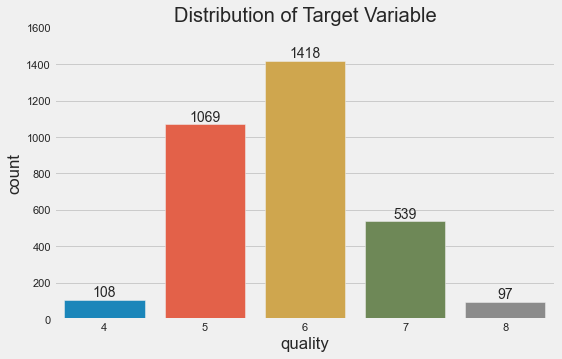

In [11]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(train['quality'])

ax.bar_label(ax.containers[0])
plt.title("Distribution of Target Variable")

ax.set_ylim(0, 1600)

plt.show()

In [12]:
train.quality.value_counts(normalize=True)

6    0.438873
5    0.330857
7    0.166821
4    0.033426
8    0.030022
Name: quality, dtype: float64

<br>

### 수치형 변수 분포

수치형 변수들의 분포를 train과 test 함께 비교해본 결과, train과 test가 거의 비슷하게 분포하고 있음을 알 수 있습니다.

왜도를 함께 확인한 결과, chlorides 변수를 제외하고는 치우침이 크지 않은 것으로 보입니다.(-2와 +2 사이가 기준)

변수 중에 치우친 변수가 있기 때문에 데이터 스케일링이 필요하다고 판단됩니다.



In [13]:
num_cols = list(train._get_numeric_data().columns[:-1])
df = pd.concat([train[num_cols], test[num_cols]], axis=0)
df['label'] = 'test'
df['label'][:3231] = 'train'

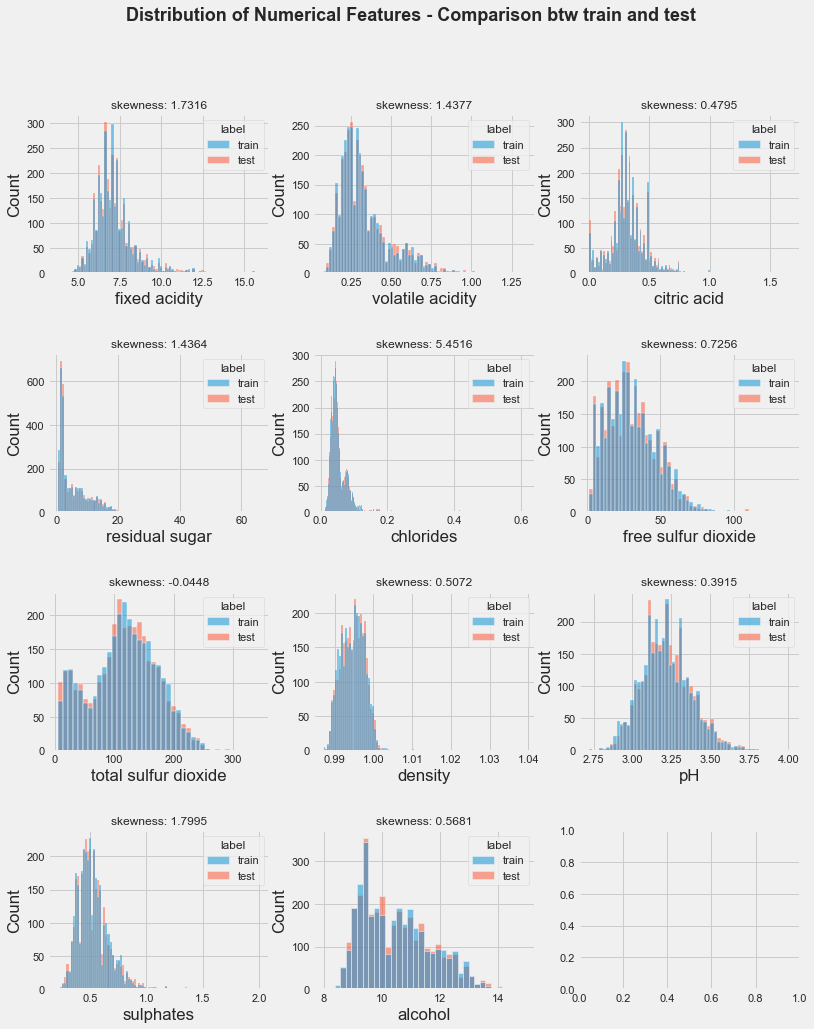

In [14]:
fig, axes = plt.subplots(4, 3, figsize = (12, 15), sharey=False)

for i, feature in enumerate(num_cols):
    sns.histplot(data = df, x = feature, hue = 'label', ax = axes[i//3][i%3])
    axes[i//3][i%3].set_title(f'skewness: {df[feature].skew():.4f}', fontsize = 12)
    plt.subplots_adjust(hspace = 0.5)
    
fig.suptitle('Distribution of Numerical Features - Comparison btw train and test', fontsize = 18,fontweight='bold')
plt.show()

<br>

### 범주형 변수 분포

train, test 데이터 간의 불균형은 없으나, red에 비해 white에 대한 비중이 3배 이상 높은 것으로 보입니다.



In [15]:
cat_col = 'type'
df2 = pd.concat([pd.DataFrame(train[cat_col]), pd.DataFrame(test[cat_col])])
df2['label'] = 'test'
df2['label'][:3231] = 'train'

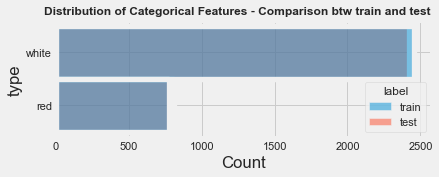

In [16]:
plt.figure(figsize = (6, 2))

sns.histplot(data = df2, y = 'type', hue = 'label')

plt.suptitle('Distribution of Categorical Features - Comparison btw train and test', fontsize = 12,fontweight='bold')
plt.show()

<br>

### 각 독립변수별 quality와의 관계 분석

각 변수들이 quality에 미치는 영향이 유의미한지를 확인해 보고자 합니다. 

<br>

In [17]:
# 피벗테이블 생성
def create_pivot(n):
    pivot_df = pd.pivot_table(data = train, index = 'quality', values = num_cols[n], aggfunc = ['mean', 'count'])
    pivot_df['ratio, %'] = round(pivot_df[('count', num_cols[n])] / len(train) * 100, 2)
    return pivot_df

# hist plot 생성
def create_plot(n):
    sns.histplot(data = train, x = num_cols[n], hue = 'quality', palette = 'colorblind')
    plt.show()

<br>

#### fixed acidity: 고정(비휘발성) 산도
+ 와인과 관련된 대부분의 산

<br>

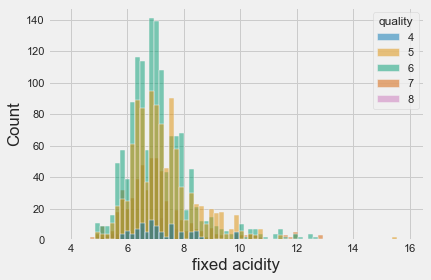

,mean,count,"ratio, %"
,fixed acidity,fixed acidity,
quality,,,
4,7.275926,108,3.34
5,7.339757,1069,33.09
6,7.161142,1418,43.89
7,7.127180,539,16.68
8,6.740206,97,3.00


None

In [18]:
display(create_pivot(0), create_plot(0))

<br>

#### volatile acidity : 휘발성 산도
+ 와인에 함유된 아세트산의 양. 너무 높으면 불쾌한 식초 맛이 날 수 있음

<br>

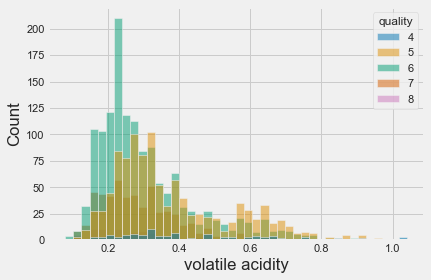

,mean,count,"ratio, %"
,volatile acidity,volatile acidity,
quality,,,
4,0.469028,108,3.34
5,0.383634,1069,33.09
6,0.309870,1418,43.89
7,0.292653,539,16.68
8,0.288196,97,3.00


None

In [19]:
display(create_pivot(1), create_plot(1))

<br>

#### citric acid : 구연산
+ 소량으로 발견되며, 와인에 풍미를 더할 수 있음

<br>

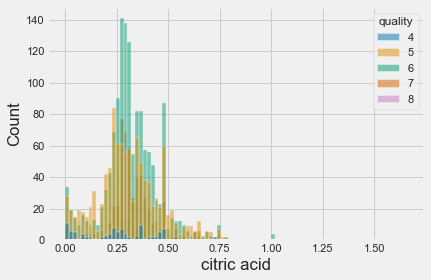

,mean,count,"ratio, %"
,citric acid,citric acid,
quality,,,
4,0.260926,108,3.34
5,0.313143,1069,33.09
6,0.323886,1418,43.89
7,0.331633,539,16.68
8,0.323093,97,3.00


None

In [20]:
display(create_pivot(2), create_plot(2))

<br>

#### residual sugar : 잔여 당분
+ 발효가 멈춘 후 남은 설탕의 양으로 1g/L 미만의 와인은 드물며 45g/L 이상의 와인은 단맛으로 간주함

<br>

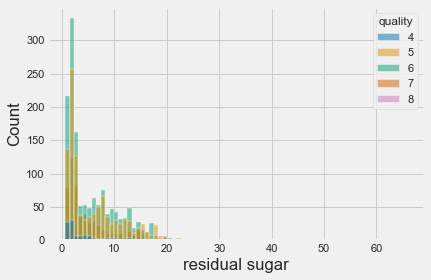

,mean,count,"ratio, %"
,residual sugar,residual sugar,
quality,,,
4,3.962037,108,3.34
5,5.889476,1069,33.09
6,5.548942,1418,43.89
7,4.679221,539,16.68
8,5.260309,97,3.00


None

In [21]:
display(create_pivot(3), create_plot(3))

<br>

#### chlorides: 염소화물
+ 와인의 염분량

<br>

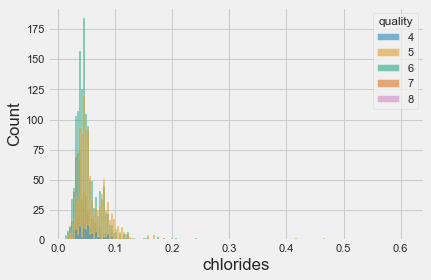

,mean,count,"ratio, %"
,chlorides,chlorides,
quality,,,
4,0.056972,108,3.34
5,0.064714,1069,33.09
6,0.054214,1418,43.89
7,0.045111,539,16.68
8,0.041825,97,3.00


None

In [22]:
display(create_pivot(4), create_plot(4))

<br>

#### free sulfur dioxide: 유리 이산화황
+ 미생물의 성장과 와인의 산화를 방지함

<br>

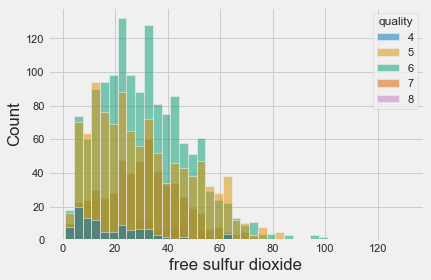

,mean,count,"ratio, %"
,free sulfur dioxide,free sulfur dioxide,
quality,,,
4,20.796296,108,3.34
5,30.526193,1069,33.09
6,30.960860,1418,43.89
7,30.725417,539,16.68
8,35.814433,97,3.00


None

In [23]:
display(create_pivot(5), create_plot(5))

<br>

#### total sulfur dioxide : 총 이산화황
+ 저농도에서는 대부분 맛이 나지 않으나 50ppm 이상의 농도에서 맛에서 뚜렷하게 나타남

<br>

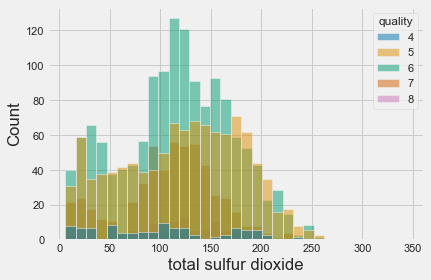

,mean,count,"ratio, %"
,total sulfur dioxide,total sulfur dioxide,
quality,,,
4,104.356481,108,3.34
5,121.696445,1069,33.09
6,115.722849,1418,43.89
7,108.591837,539,16.68
8,119.948454,97,3.00


None

In [24]:
display(create_pivot(6), create_plot(6))

<br>

#### density : 밀도
+ 알코올 및 당 함량에 따라 변함

<br>

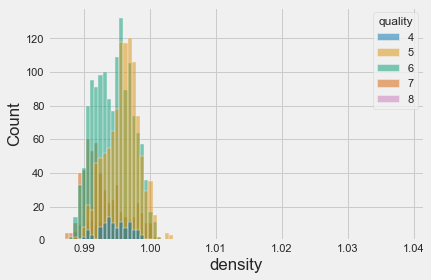

,mean,count,"ratio, %"
,density,density,
quality,,,
4,0.994770,108,3.34
5,0.995868,1069,33.09
6,0.994518,1418,43.89
7,0.993034,539,16.68
8,0.992576,97,3.00


None

In [25]:
display(create_pivot(7), create_plot(7))

<br>

#### pH : 산성 또는 염기성 정도
+ 0(매우 산성) ~ 14(매우 염기성). 대부분의 와인은 pH 3-4 사이임

<br>

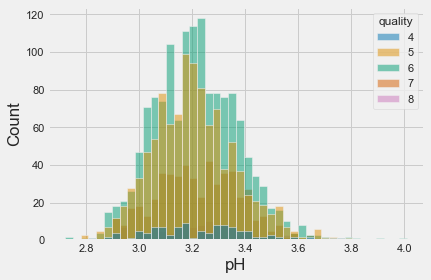

,mean,count,"ratio, %"
,pH,pH,
quality,,,
4,3.232870,108,3.34
5,3.204995,1069,33.09
6,3.213801,1418,43.89
7,3.225733,539,16.68
8,3.235464,97,3.00


None

In [26]:
display(create_pivot(8), create_plot(8))

<br>

#### sulphates : 황산염
+ 이산화황 농도에 기여할 수 있는 와인 첨가제. 항균 및 항산화제로 작용

<br>

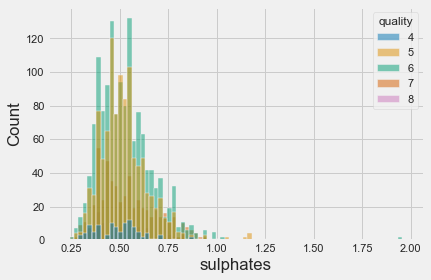

,mean,count,"ratio, %"
,sulphates,sulphates,
quality,,,
4,0.505833,108,3.34
5,0.529897,1069,33.09
6,0.531065,1418,43.89
7,0.542801,539,16.68
8,0.519794,97,3.00


None

In [27]:
display(create_pivot(9), create_plot(9))

<br>

#### alcohol : 와인의 알코올 함량. 백분율

<br>

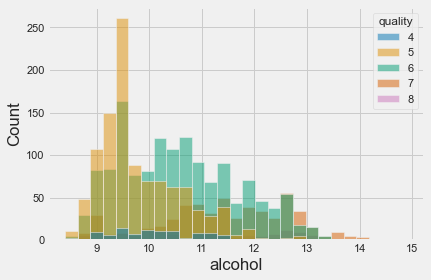

,mean,count,"ratio, %"
,alcohol,alcohol,
quality,,,
4,10.180556,108,3.34
5,9.846333,1069,33.09
6,10.578573,1418,43.89
7,11.445659,539,16.68
8,11.559794,97,3.00


None

In [28]:
display(create_pivot(10), create_plot(10))

<br>

#### type : 와인에 사용된 포도의 종류
+ Red(적포도주), White(백포도주)로 나뉨

<br>

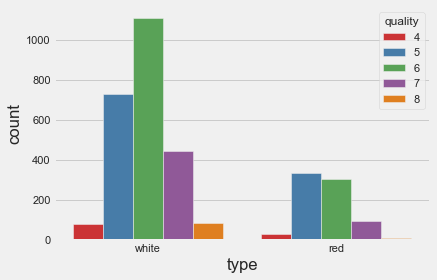

In [29]:
sns.countplot(data = train, x = 'type', hue = 'quality', palette = 'Set1')
plt.show()

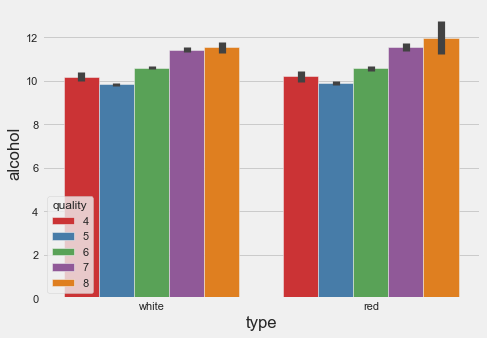

In [30]:
plt.figure(figsize=(7, 5))

sns.barplot(data = train, x = 'type', y = 'alcohol', hue = 'quality', palette = 'Set1')

plt.show()

<br>

#### 상관관계 분석

<br>

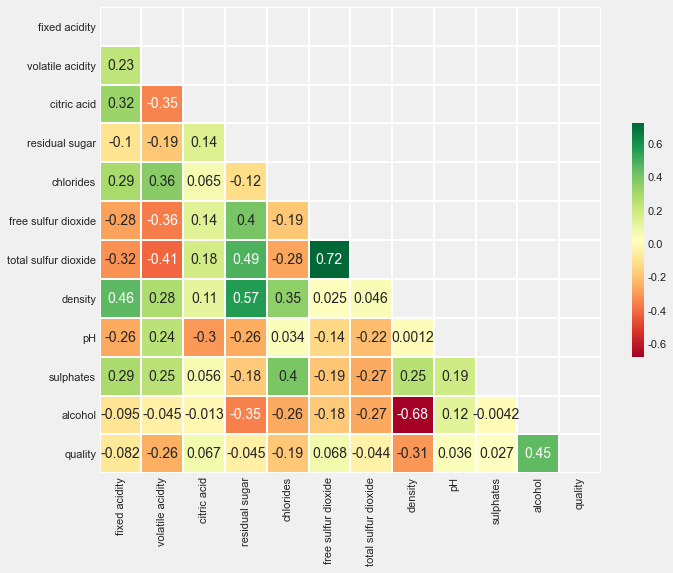

In [31]:
corr = train.corr()

plt.figure(figsize = (10, 8))

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

heat_map = sns.heatmap(corr,
                       annot = True,
                       cmap = 'RdYlGn',
                       mask = mask,
                       linewidths = 0.01,
                       cbar_kws = {'shrink' : .5})

<br>

**파생변수 생성 아이디어**

1. quality와 상관관계가 높은 변수들 확인
    + 그 변수의 분포를 확인 후 변수 내의 클래스 분포가 유의미하다면 해당 변수의 클래스별 통계량 변수 생성
    + 그 변수와 상관관계가 높은 다른 독립변수와의 곱셈 변수 생성
    + alcohol
        * quality와 0.45 양의 상관관계
        * type별, 클래스별 alcohol의 차이 확인
        
   
    
    
2. quality와 상관관계는 낮지만 서로 상관관계가 높은 독립변수들 확인
    + 파생변수 생성 방법은 위와 동일함
    + fixed acidity
        * 종속변수와 상관관계가 거의 없음
        * 양의 상관관계: density, citric acid, chlorides, sulphates



3. 아래의 기본 변수 이용 예측을 보면 6이 제일 많음에도 6의 precision이 낮은 편임. 6의 특징을 이용한 변수를 생성한다면 효과가 있을 것으로 판단됨


<br>

<br>

## Feature Engineering

in progress..


<br>

## 데이터 전처리

* type 변수: one-hot encoding으로 더미변수화
* numeric 변수: standard scaling으로 centering


In [26]:
# one-hot encoding

train_df = pd.get_dummies(train)
test_df = pd.get_dummies(test)

display(train_df.shape, train_df.head(1), test_df.shape, test_df.head(1))

(3231, 14)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
id,,,,,,,,,,,,,,
1,8.0,0.18,0.37,1.3,0.04,15.0,96.0,0.9912,3.06,0.61,12.1,6,0,1


(3231, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
id,,,,,,,,,,,,,
1,7.3,0.31,0.25,6.65,0.032,30.0,138.0,0.99244,2.9,0.37,11.1,0,1


In [27]:
# standard scaling to make the numeric variables

ss = StandardScaler()

for col in num_cols:
    train_df[col] = ss.fit_transform(train_df[[col]])
    test_df[col] = ss.fit_transform(test_df[[col]])
    
display(train_df.head(2), test_df.head(2))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
id,,,,,,,,,,,,,,
1,0.613164,-0.973871,0.346320,-0.862826,-0.444893,-0.896417,-0.363344,-1.135570,-0.952533,0.524814,1.342873,6,0,1
2,0.227151,0.274102,-0.202257,-0.115217,-0.976867,0.426604,-0.058413,-1.443438,-0.828960,-0.343803,2.096877,7,0,1


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
id,,,,,,,,,,,,,
1,0.063011,-0.191206,-0.470589,0.258118,-0.707904,-0.022119,0.403475,-0.775939,-2.026277,-1.089432,0.515259,0,1
2,1.146747,2.162839,-0.539777,-0.624624,5.007836,-1.470535,-1.770665,1.489262,0.613957,0.462904,-1.248324,1,0


<br>

## 모델 생성

* train_test_split
* k-fold cross validation
* creating lgbm classifier
* model evaluation


In [28]:
X_trn = train_df.drop('quality', axis=1).reset_index(drop=True)
y_trn = train_df['quality'].reset_index(drop=True)
X_tst = test_df.reset_index(drop=True)

display(X_trn.shape, y_trn.shape, X_tst.shape)

(3231, 13)

(3231,)

(3231, 13)

<br>

### 종속변수 불균형상태에서의 모델 생성 및 성능평가

<br>

In [29]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds_lgb = []
mean_acc = 0

model_lgb = LGBMClassifier(objective = 'multiclass', random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model_lgb.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = 'logloss',
             early_stopping_rounds = 100)
    
    y_preds = model_lgb.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds_lgb.append(model_lgb.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.6543
Fold 1's score: 0.6378
Fold 2's score: 0.6161
Fold 3's score: 0.6316
Fold 4's score: 0.6006
Fold 5's score: 0.6130
Fold 6's score: 0.6316
Fold 7's score: 0.6563
Fold 8's score: 0.6471
Fold 9's score: 0.6347
Mean auc of all folds: 0.6323


In [30]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds_xgb = []
mean_acc = 0

model_xgb = XGBClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model_xgb.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = 'mlogloss',
             early_stopping_rounds = 100)
    
    y_preds = model_xgb.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds_xgb.append(model_xgb.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.6235
Fold 1's score: 0.6192
Fold 2's score: 0.6037
Fold 3's score: 0.6440
Fold 4's score: 0.6037
Fold 5's score: 0.5882
Fold 6's score: 0.6254
Fold 7's score: 0.6254
Fold 8's score: 0.6347
Fold 9's score: 0.6563
Mean auc of all folds: 0.6224


In [31]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds_rf = []
mean_acc = 0

model_rf = RandomForestClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model_rf.fit(X_train, y_train)
    
    y_preds = model_rf.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds_rf.append(model_rf.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.6543
Fold 1's score: 0.6254
Fold 2's score: 0.6409
Fold 3's score: 0.6316
Fold 4's score: 0.5975
Fold 5's score: 0.6068
Fold 6's score: 0.6502
Fold 7's score: 0.6749
Fold 8's score: 0.6749
Fold 9's score: 0.6656
Mean auc of all folds: 0.6422


In [32]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds_et = []
mean_acc = 0

model_et = ExtraTreesClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model_et.fit(X_train, y_train)
    
    y_preds_et = model_et.predict(X_val)
    score = accuracy_score(y_val, y_preds_et)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds_et.append(model_et.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.6574
Fold 1's score: 0.6533
Fold 2's score: 0.6440
Fold 3's score: 0.6502
Fold 4's score: 0.6192
Fold 5's score: 0.6130
Fold 6's score: 0.6440
Fold 7's score: 0.6563
Fold 8's score: 0.6563
Fold 9's score: 0.6656
Mean auc of all folds: 0.6459


In [33]:
print(classification_report(y_val, y_preds_et))

              precision    recall  f1-score   support

           4       0.67      0.18      0.29        11
           5       0.77      0.64      0.70       107
           6       0.61      0.83      0.70       141
           7       0.71      0.44      0.55        54
           8       0.57      0.40      0.47        10

    accuracy                           0.67       323
   macro avg       0.67      0.50      0.54       323
weighted avg       0.68      0.67      0.65       323



4를 기준으로 classification report를 해석하면 다음과 같습니다.

classification report는 학습데이터 기준이 아닌 validation set을 기준으로 보는 것이 더욱 중요합니다.

이유는, 학습데이터는 잘 학습했지만 validation set을 예측한 결과는 엉망일 수 있고, 이 경우 모델을 validation set에 대한 예측 기준으로 평가해야 해당 모델에 대한 올바른 평가를 내릴 수 있기 때문입니다.

1. precision(정밀도): 4라고 예측한 것들 중 실제로 4일 확률 --> 타 클래스와 비슷한 수준
2. recall(재현율): 실제로 4인 것들 중 모델이 4로 예측한 확률 --> 유독 4를 맞추는 게 어렵다
3. F1(정밀도와 재현율의 가중조화평균): 4를 맞추는 게 어렵다

<br>

<br>

### 불균형 데이터 확인 및 SMOTE, ADASYN으로 오버샘플링한 데이터 생성

[참고 커널](https://www.kaggle.com/vislupus/smote-red-wine-quality)


**불균형 데이터 문제**

희귀병의 양성/음성을 예로 들면, 음성이 훨씬 많고 양성은 굉장히 적을 것입니다.

모델을 만들 시, 양성을 제대로 예측하는 것이 중요한데, 불균형 데이터는 `accuracy`가 높아도 `재현율(recall: 실제 양성을 양성으로 예측할 확률)` 이 급격히 작아지는데, 가령 데이터에 양성이 3명, 음성이 97명이라면 그냥 전부 음성이라고 예측해도 정확도가 97%가 됩니다. 

정확도 기준으로는 훌륭한 모델이지만, recall 기준으로는 이 모델은 양성인 사람을 거의 예측할 수 없는 엉터리 모델일 수 있다는 뜻입니다.

이 경우 불균형을 해결하기 위한 기법은 다음과 같습니다.


* undersampling
    + 무작위 추출: 무작위로 음성 데이터(정상 데이터, 즉 비중이 높은 클래스의 데이터) 중 일부만 선택
    + 유의정보: 유의한 데이터만을 남기는 방식
    + 단점: 데이터 정보 손실이 매우 커짐. 무작위이므로 실제로는 정말 중요했을 수 있는 데이터를 잃을 수 있음
    

* oversampling
    + 무작위 추출: 무작위로 양성 데이터(소수 클래스)를 복제
    + 장점: 정보손실이 없음
    + 단점: 복제된 관측치를 original data set에 추가하기만 하기 때문에, 과대적합(overfitting)을 초래할 수 있다.
    + 방안: 합성 데이터 생성 - 소수 데이터를 단순 복제하는 것이 아닌, 새로운 복제본을 만들어 낸다.


* SMOTE(Synthetic Minority Oversampling TEchnique: 합성 소수 샘플링 기술)
    + 합성데이터를 생성하는 기법
    + 다수클래스를 샘플링하고, 기존 소수 샘플을 보간하여 새로운 소수 인스턴스를 합성해낸다.
    + 일반적으로 잘 작동하나, 학습데이터 내의 소수데이터들 사이의 특성만 반영되어 작동하므로 새로운 사례의 데이터에 취약할 수 있음
    + 또한 over-generalization문제 발생 가능 --> 주변 샘플에 대한 고려 없이 소수클래스에 속하는 모든 개별 샘플들에 대해 동일한 방법으로 합성데이터를 생성(말이 좀 어려운데,, 지나친 일반화가 된다고 이해하고 넘어가도 됩니다)
    
    
* ADASYN(Adaptive Synthetic Sampling)
    + SMOTE와 비슷한 방식으로 샘플링
    + SMOTE의 over generalization문제 해결을 위해 제안된 적응형 방법
    + 주위 데이터의 분포에 따라 발생시킬 합성 데이터 수를 좀 더 체계적으로 조절하며 작동

<br>

In [34]:
# Counter, SMOTE, ADASYN import는 맨 위 참고

Counter(y_trn)

Counter({6: 1418, 7: 539, 5: 1069, 8: 97, 4: 108})

In [35]:
# 클래스 별로 3000개로 구성되도록 오버샘플링

oversample_smote = SMOTE(sampling_strategy = {6: 3000, 7: 3000, 5: 3000, 8: 3000, 4: 3000},
                         random_state = RANDOM_SEED)

X_smote, y_smote = oversample_smote.fit_resample(X_trn, y_trn)

counter_smote = Counter(y_smote)
print(counter_smote)

Counter({6: 3000, 7: 3000, 5: 3000, 8: 3000, 4: 3000})


In [36]:
# 위 설명에서 "주위 데이터의 분포에 따라 발생시킬 합성 데이터 수를 좀 더 체계적으로 조절하며 작동" 이라고 한 것처럼 
# 3000개로 입력해도 클래스 별 갯수는 각각 다르게 오버샘플링 됨

oversample_adasyn = ADASYN(sampling_strategy = {6: 3000, 7: 3000, 5: 3000, 8: 3000, 4: 3000},
                           random_state = RANDOM_SEED)

X_adasyn, y_adasyn = oversample_adasyn.fit_resample(X_trn, y_trn)

counter_adasyn = Counter(y_adasyn)
print(counter_adasyn)

Counter({5: 3047, 7: 3034, 8: 2997, 4: 2989, 6: 2731})


<br>

### SMOTE를 이용한 오버샘플링 데이터로 모델 생성 및 성능 평가

<br>

In [37]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds = []
mean_acc = 0

model_lgb = LGBMClassifier(objective = 'multiclass', random_state = RANDOM_SEED, boosting_from_average = False)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_smote, y_smote)):
    X_train, X_val = X_smote.loc[trn_idx], X_smote.loc[val_idx]
    y_train, y_val = y_smote.loc[trn_idx], y_smote.loc[val_idx]
    
    model_lgb.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = 'logloss',
             early_stopping_rounds = 100)
    
    y_preds = model_lgb.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds.append(model_lgb.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.8653
Fold 1's score: 0.8760
Fold 2's score: 0.8707
Fold 3's score: 0.8707
Fold 4's score: 0.8747
Fold 5's score: 0.8653
Fold 6's score: 0.8653
Fold 7's score: 0.8747
Fold 8's score: 0.8727
Fold 9's score: 0.8793
Mean auc of all folds: 0.8715


In [38]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds = []
mean_acc = 0

model_xgb = XGBClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_smote, y_smote)):
    X_train, X_val = X_smote.loc[trn_idx], X_smote.loc[val_idx]
    y_train, y_val = y_smote.loc[trn_idx], y_smote.loc[val_idx]
    
    model_xgb.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = 'mlogloss',
             early_stopping_rounds = 100)
    
    y_preds = model_xgb.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds.append(model_xgb.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.9087
Fold 1's score: 0.9173
Fold 2's score: 0.9193
Fold 3's score: 0.9193
Fold 4's score: 0.9333
Fold 5's score: 0.9067
Fold 6's score: 0.9160
Fold 7's score: 0.9160
Fold 8's score: 0.9027
Fold 9's score: 0.9200
Mean auc of all folds: 0.9159


In [39]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds = []
mean_acc = 0

model_rf = RandomForestClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_smote, y_smote)):
    X_train, X_val = X_smote.loc[trn_idx], X_smote.loc[val_idx]
    y_train, y_val = y_smote.loc[trn_idx], y_smote.loc[val_idx]
    
    model_rf.fit(X_train, y_train)
    
    y_preds = model_rf.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds.append(model_rf.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.9467
Fold 1's score: 0.9493
Fold 2's score: 0.9427
Fold 3's score: 0.9480
Fold 4's score: 0.9600
Fold 5's score: 0.9440
Fold 6's score: 0.9453
Fold 7's score: 0.9473
Fold 8's score: 0.9393
Fold 9's score: 0.9547
Mean auc of all folds: 0.9477


In [40]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds_et_smote = []
mean_acc = 0

model_et = ExtraTreesClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_smote, y_smote)):
    X_train, X_val = X_smote.loc[trn_idx], X_smote.loc[val_idx]
    y_train, y_val = y_smote.loc[trn_idx], y_smote.loc[val_idx]
    
    model_et.fit(X_train, y_train)
    
    y_preds = model_et.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds_et_smote.append(model_et.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.9600
Fold 1's score: 0.9553
Fold 2's score: 0.9613
Fold 3's score: 0.9667
Fold 4's score: 0.9700
Fold 5's score: 0.9640
Fold 6's score: 0.9600
Fold 7's score: 0.9680
Fold 8's score: 0.9573
Fold 9's score: 0.9600
Mean auc of all folds: 0.9623


In [345]:
# ExtraTreesClassifier 의 마지막 validation 예측 값 기준

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           4       0.95      0.99      0.97       142
           5       0.82      0.80      0.81       142
           6       0.76      0.67      0.71       141
           7       0.88      0.91      0.89       142
           8       0.95      1.00      0.98       142

    accuracy                           0.88       709
   macro avg       0.87      0.88      0.87       709
weighted avg       0.87      0.88      0.87       709



<br>

일단 내부 평가의 accuracy score가 상당히 올라갔습니다. 

대부분 90%를 훌쩍 넘는 accuracy를 보였고, classification report를 보면 precision도 그렇지만 recall이 기존 불균형 상태에서의 결과 대비 엄청나게 좋아진 것을 알 수 있습니다.

오히려 6에 대한 precision과 recall이 꽤 낮아졌음을 알 수 있습니다.

해석은 자유롭게 하면 되는데, 저의 생각은 qualtiy 6이 굉장히 특징적이었으나 오버샘플링으로 다른 클래스들과 균형이 맞춰지자 qualtiy 6의 특징이 희석된 것으로 보입니다.

이 경우 언더샘플링도 해본다면 좀 더 알 수 있을 것 같습니다.


<br>

<br>

### ADASYN을 이용한 오버샘플링 데이터로 모델 생성 및 성능 평가

<br>

In [142]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds = []
mean_acc = 0

model_lgb = LGBMClassifier(objective = 'multiclass', random_state = RANDOM_SEED, boosting_from_average = False)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_adasyn, y_adasyn)):
    X_train, X_val = X_adasyn.loc[trn_idx], X_adasyn.loc[val_idx]
    y_train, y_val = y_adasyn.loc[trn_idx], y_adasyn.loc[val_idx]
    
    model_lgb.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = 'logloss',
             early_stopping_rounds = 100)
    
    y_preds = model_lgb.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds.append(model_lgb.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.8541
Fold 1's score: 0.8588
Fold 2's score: 0.8547
Fold 3's score: 0.8405
Fold 4's score: 0.8392
Fold 5's score: 0.8473
Fold 6's score: 0.8439
Fold 7's score: 0.8365
Fold 8's score: 0.8553
Fold 9's score: 0.8614
Mean auc of all folds: 0.8492


In [143]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds = []
mean_acc = 0

model_xgb = XGBClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_adasyn, y_adasyn)):
    X_train, X_val = X_adasyn.loc[trn_idx], X_adasyn.loc[val_idx]
    y_train, y_val = y_adasyn.loc[trn_idx], y_adasyn.loc[val_idx]
    
    model_xgb.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = 'mlogloss',
             early_stopping_rounds = 100)
    
    y_preds = model_xgb.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds.append(model_xgb.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.9101
Fold 1's score: 0.9108
Fold 2's score: 0.9155
Fold 3's score: 0.9115
Fold 4's score: 0.8818
Fold 5's score: 0.9041
Fold 6's score: 0.8973
Fold 7's score: 0.8899
Fold 8's score: 0.8979
Fold 9's score: 0.9162
Mean auc of all folds: 0.9035


In [144]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds = []
mean_acc = 0

model_rf = RandomForestClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_adasyn, y_adasyn)):
    X_train, X_val = X_adasyn.loc[trn_idx], X_adasyn.loc[val_idx]
    y_train, y_val = y_adasyn.loc[trn_idx], y_adasyn.loc[val_idx]
    
    model_rf.fit(X_train, y_train)
    
    y_preds = model_rf.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds.append(model_rf.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.9432
Fold 1's score: 0.9493
Fold 2's score: 0.9392
Fold 3's score: 0.9453
Fold 4's score: 0.9318
Fold 5's score: 0.9399
Fold 6's score: 0.9338
Fold 7's score: 0.9351
Fold 8's score: 0.9459
Fold 9's score: 0.9466
Mean auc of all folds: 0.9410


In [145]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds = []
mean_acc = 0

model_et = ExtraTreesClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_adasyn, y_adasyn)):
    X_train, X_val = X_adasyn.loc[trn_idx], X_adasyn.loc[val_idx]
    y_train, y_val = y_adasyn.loc[trn_idx], y_adasyn.loc[val_idx]
    
    model_et.fit(X_train, y_train)
    
    y_preds = model_et.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds.append(model_et.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.9622
Fold 1's score: 0.9601
Fold 2's score: 0.9628
Fold 3's score: 0.9628
Fold 4's score: 0.9514
Fold 5's score: 0.9608
Fold 6's score: 0.9554
Fold 7's score: 0.9493
Fold 8's score: 0.9628
Fold 9's score: 0.9608
Mean auc of all folds: 0.9588


<br>

### 제출 후 Accuracy 비교 결과: 학습데이터에 과적합

이대로 제출을 하면 점수는 어떻게 될지 살펴봤는데 학습데이터에 굉장히 과적합된 모델이 되었음을 알 수 있었습니다. 


* 불균형: 0.65
* SMOTE: 0.63
* ADASYN: 굳이 제출해볼 필요 없을 듯.

<br>

<br>

SMOTE 적용 후의 수치형 변수는 quality 별로 어떻게 달라졌을까?

결론적으로 크게 달라진 게 없는데요,

이유는 기존의 변수들의 분포를 보면 분포의 형태로 quality를 구분해 볼 수 있는 마땅한 변수가 없습니다.

즉 SMOTE나 ADASYN이 효과가 없는 라이브러리라는 것이 아닌, 데이터 자체가 quality를 정확히 예측하는 데에 효과가 크지 않은 데이터라고 할 수 있을 것 같다는 생각입니다. 

이를테면 alcohol은 quality와 상관관계가 0.45로 가장 높지만 아래 시각화를 보시면 클래스별로 고루 분포되어 있습니다.

그렇기 때문에, Alcohol 도수가 높을수록 quality가 높아진다던지.. 반대로 낮을수록 높아진다던지 하는 특징을 잡아내기가 어렵습니다.

이 경우는 모델의 성능을 끌어올리려고 여러 모델을 써보는 건 큰 효과가 없을 가능성이 높을 것 같습니다.
(효과는 있어도 획기적인 개선이 어려울 듯..)

따라서 만약 실제 와인회사의 데이터 분석 담당이라면 이 경우 외부 데이터를 이용한다던지, 새로운 변수들을 추가 수집하는 것이 필요합니다. 예를 들어 포도의 품종, 브랜드, 숙성기간, 제조국가 등 와인의 품질에 영향을 미치는 요소는 많습니다.

또는 기존 변수 내에서 수치형 변수의 구간을 나눠서 명목형 변수화 하여 파생변수를 만들어 보는 것도 좋을 것 같습니다.

대회 게시판 글을 보면 알 수 있듯이 모 회원이 규정위반으로 탈락하긴 했지만 외부데이터를 약간 이용했더니 0.7 이상으로 점수가 크게 상승했던 경우가 있죠.

다만 이 대회는 연습용으로 외부데이터 사용을 금지하고 있으므로 오히려 이 데이터를 통해 판다스나 시각화 연습, 또는 모델의 이론적인 부분, 불균형 데이터 다루는 방법, 또는 단지 1%의 상승이 있더라도 유의미한 파생변수를 변수 간 상관관계를 고려하여 직접 만들어 보는 연습 등등 다양한 학습과 시도의 측면으로 하시는 게 좋을 것 같습니다.

<br>

In [41]:
smote_train = X_smote.copy()
smote_train['quality'] = y_smote
smote_train.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white,quality
0,0.613164,-0.973871,0.34632,-0.862826,-0.444893,-0.896417,-0.363344,-1.13557,-0.952533,0.524814,1.342873,0,1,6


In [42]:
# 피벗테이블 생성
def create_pivot_smote(n):
    pivot_df = pd.pivot_table(data = smote_train, index = 'quality', values = num_cols[n], aggfunc = ['mean', 'count'])
    pivot_df['ratio, %'] = round(pivot_df[('count', num_cols[n])] / len(smote_train) * 100, 2)
    return pivot_df

# hist plot 생성
def create_plot_smote(n):
    sns.histplot(data = smote_train, x = num_cols[n], hue = 'quality', palette = 'colorblind')
    plt.show()

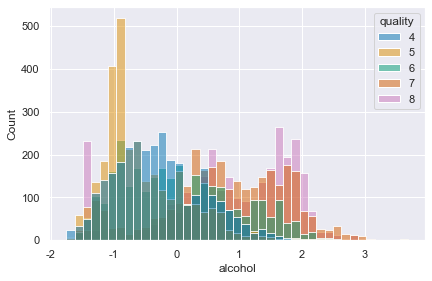

,mean,count,"ratio, %"
,alcohol,alcohol,
quality,,,
4,-0.280718,3000,20.0
5,-0.547277,3000,20.0
6,0.046511,3000,20.0
7,0.784797,3000,20.0
8,0.868457,3000,20.0


None

,mean,count,"ratio, %"
,alcohol,alcohol,
quality,,,
4,10.180556,108,3.34
5,9.846333,1069,33.09
6,10.578573,1418,43.89
7,11.445659,539,16.68
8,11.559794,97,3.00


In [43]:
display(create_pivot_smote(10), create_plot_smote(10), create_pivot(10))

<br>

## 예측 및 제출

In [206]:
preds = np.mean(preds_et_smote, axis = 0)  # ExtraTreesClassifier smote 기준으로 제출

final_preds = np.round(preds).astype('int64')

In [207]:
# submission = pd.read_csv('./dataset/sample_submission.csv')

# submission['quality'] = final_preds

In [208]:
# submission.to_csv('./dataset/submission_05.csv', index=False)